# **1. ライブラリのインストール**


In [1]:
!pip install onnx
!pip install onnxruntime
!pip install skl2onnx
!apt-get install -y mecab mecab-ipadic-utf8 libmecab-dev
!pip install mecab-python3 unidic-lite scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
tensorfl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 22 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd64 0.996-14build9 [136 kB]
Get:6 http://archive.ubuntu.co

# **2. 必要なライブラリのインポート**

In [2]:
import pandas as pd #to handle dataset
import numpy as np
import re
import MeCab
import onnx
import onnxruntime as ort
from sklearn.feature_extraction.text import CountVectorizer #for convert text data to numerical data
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# **3. データセットの読み込みと前処理**

In [3]:
# データセットの読み込み
data = pd.read_csv('/content/新data.csv')
data = data.drop(columns=['Unnamed', 'message_length'], errors='ignore')  # 不要な列を削除（存在しない場合は無視）
#data = data.drop(columns=['No.'], errors='ignore')  # 不要な列を削除（存在しない場合は無視）

In [4]:
data.shape

(11203, 2)

In [5]:
data = data.sample(frac=1)
data.head(5)

,message,label
1394,【無料ギフト】今すぐ受け取るチャンス！詳細はこちら: http://fake134.jp,spam
5132,週末の予定は？映画でも見に行こうよ！,ham
8862,おめでとうございます！52万円が当選しました。受け取りはこちら: http://fake64...,spam
7752,この前借りた本、すごく面白かったよ！ありがとう！,ham
4284,【注意】クレジットカードの利用確認が必要です。リンク: http://fake338.jp,spam


In [6]:
#missing values
data.isnull().sum()

,0
message,0
label,0


# **4. 日本語ストップワードの定義とテキスト前処理**

In [7]:
# 日本語ストップワードリスト
japanese_stopwords = set(
    """
あ あっ あまり あり ある あるいは あれ
い いい いう いく いずれ いっ いつ いる いわ
うち
え
お おい おけ および おら おり
か かけ かつ かつて かなり から が
き きっかけ
くる くん
こ こう ここ こと この これ ご ごと
さ さらに さん
し しか しかし しまう しまっ しよう
す すぐ すべて する ず
せ せい せる
そう そこ そして その それ それぞれ
た たい ただし たち ため たら たり だ だけ だっ
ち ちゃん
つ つい つけ つつ
て で でき できる です
と とき ところ とっ とも どう
な ない なお なかっ ながら なく なけれ なし なっ など なら なり なる
に にて
ぬ
ね
の のち のみ
は はじめ ば
ひと
ぶり
へ べき
ほか ほとんど ほど ほぼ
ま ます また まで まま
み
も もう もっ もと もの
や やっ
よ よう よく よっ より よる よれ
ら らしい られ られる
る
れ れる
を
ん
一
""".split()
)

def preprocess_text(text):
    text = re.sub(r'\d+', '', text)  # 数字を削除
    text = re.sub(r'http\S+', '', text)  # URLを削除
    text = re.sub(r'[!-/:-@[-`{-~]', '', text)  # ASCII symbolsを削除
    text = re.sub(r'[、。【】「」、？・！\n]', ' ', text)  # Japanese punctuationを削除
    text = re.sub(r'\s+', ' ', text).strip()  # extra spacesを削除
    text = ' '.join([word for word in text.split() if word not in japanese_stopwords])  # ストップワード削除
    return text

In [8]:
#Tokenization using MeCab

mecab = MeCab.Tagger("-Owakati")  # "Owakati" mode splits text into words with spaces
data['cleaned_message'] = data['message'].apply(preprocess_text)  # Create a new 'cleaned_message' column
data['tokenized_message'] = data['cleaned_message'].apply(lambda x: mecab.parse(x).strip())

In [ ]:
data['message'][5691]

'【重要】あなたの口座に不正アクセスが検出されました。確認はこちら: http://fake142.jp'

In [ ]:
data['cleaned_message'][5691]

'重要 あなたの口座に不正アクセスが検出されました 確認はこちら'

In [ ]:
data['tokenized_message'][5691]

'重要 あなた の 口座 に 不正 アクセス が 検出 さ れ まし た 確認 は こちら'

# **5. ラベルのエンコーディング**

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
data.head()

,message,label,cleaned_message,tokenized_message
1394,【無料ギフト】今すぐ受け取るチャンス！詳細はこちら: http://fake134.jp,1,無料ギフト 今すぐ受け取るチャンス 詳細はこちら,無料 ギフト 今 すぐ 受け取る チャンス 詳細 は こちら
5132,週末の予定は？映画でも見に行こうよ！,0,週末の予定は 映画でも見に行こうよ,週末 の 予定 は 映画 で も 見 に 行こう よ
8862,おめでとうございます！52万円が当選しました。受け取りはこちら: http://fake64...,1,おめでとうございます 万円が当選しました 受け取りはこちら,お めでとう ござい ます 万 円 が 当選 し まし た 受け取り は こちら
7752,この前借りた本、すごく面白かったよ！ありがとう！,0,この前借りた本 すごく面白かったよ ありがとう,この 前 借り た 本 すごく 面白かっ た よ ありがとう
4284,【注意】クレジットカードの利用確認が必要です。リンク: http://fake338.jp,1,注意 クレジットカードの利用確認が必要です リンク,注意 クレジット カード の 利用 確認 が 必要 です リンク


# **6. ラベルの分布を確認**

In [10]:
data['label'].value_counts()

,count
label,
0,7603
1,3600


# **7. ラベルの分布を可視化**

([<matplotlib.patches.Wedge at 0x7faf76985b50>,
 [Text(-0.5854872065407898, 0.9312382783031756, 'ham'),
  Text(0.5854872937296071, -0.9312382234859032, 'spam')],
 [Text(-0.319356658113158, 0.5079481518017321, '67.87'),
  Text(0.3193567056706947, -0.5079481219014017, '32.13')])

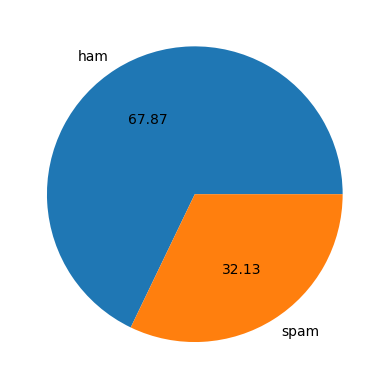

In [11]:
import matplotlib.pyplot as plt
plt.pie(data['label'].value_counts(),labels=['ham','spam'],autopct="%0.2f")

# **8. テキストデータのベクトル化**

In [12]:
def analyzer(text):
    mecab = MeCab.Tagger("-Owakati")
    return mecab.parse(text).strip().split()

vectorizer = CountVectorizer(analyzer=analyzer)
X = vectorizer.fit_transform(data['message'])
y = data['label']

# **9. データの分割**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# **10. モデルの定義**

In [14]:
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True)
}

# **11. モデルの学習と評価**

In [19]:
# 各モデルを学習し、精度を比較
import time
from sklearn.metrics import confusion_matrix
model_scores = []

for name, model in models.items():
    start_time = time.time()

    model.fit(X_train, y_train)

    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_matrix(y_test, y_pred)

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Training Time: {training_time:.2f} 秒")

    model_scores.append((name, model, accuracy))

Naive Bayes Accuracy: 0.9946444510562332
Naive Bayes Training Time: 0.01 秒
Logistic Regression Accuracy: 1.0
Logistic Regression Training Time: 0.02 秒
Random Forest Accuracy: 1.0
Random Forest Training Time: 0.64 秒
SVM Accuracy: 1.0
SVM Training Time: 5.00 秒


# **12. 精度の高いモデルを選択**

In [ ]:
# 精度の高い3つのモデルを選択
top_models = sorted(model_scores, key=lambda x: x[2], reverse=True)[:3]

In [ ]:
import pickle

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# **13. ONNX形式でのモデル保存**

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define a function to save sklearn models to ONNX
def save_sklearn_model_to_onnx(model, model_name, initial_types):
    """Saves a sklearn model to ONNX format."""
    # Update: Use 'initial_types' instead of 'initial_type'
    onnx_model = convert_sklearn(model, initial_types=initial_types)
    with open(f"{model_name}.onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())

# Save the top models to ONNX
for name, model, _ in top_models:
    if name == "Naive Bayes":
        initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]  # Adjust shape as needed
        save_sklearn_model_to_onnx(model, "naive_bayes", initial_types)
    elif name == "Logistic Regression":
        initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]  # Adjust shape as needed
        save_sklearn_model_to_onnx(model, "logistic_regression", initial_types)
    elif name == "Random Forest":
        initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]  # Adjust shape as needed
        save_sklearn_model_to_onnx(model, "random_forest", initial_types)
    elif name == "SVM":
        initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]  # Adjust shape as needed
        save_sklearn_model_to_onnx(model, "SVM", initial_types)

# Quantize the ONNX models
onnx_models = {
    "Naive Bayes": "naive_bayes.onnx",
    "Logistic Regression": "logistic_regression.onnx",
    "Random Forest": "random_forest.onnx",
    "SVM": "SVM.onnx"
}